# Laborator 6 - Segmentare Semantică

În acest laborator veți construi și antrena o rețea complet convoluțională (***FCN - Fully Convolutional Network***), al cărei rezultat este o imagine (nu doar o clasificare). Veți implementa trei tehnici speciale: ***convoluții 1x1***, ***upsampling*** și ***skip layers*** pentru a vă antrena propriul FCN.

Veți începe de la un model pre-antrenat pe ImageNet (***VGG16***). După eliminarea straturilor de clasificare (fully connected layers), veți putea adăuga cele trei tehnici (conv. 1x1, upsampling și skip layers) pentru a obține un FCN capabil să clasifice fiecare pixel din imagine.

Veți construi o rețea de segmentare semantică pentru a identifica spațiul liber pe drum (veți folosi setul de date [Kitti Road](http://www.cvlibs.net/datasets/kitti/eval_road.php)).

## De ce FCN?

O rețea convoluțională normală constă dintr-o serie de straturi convoluționale, urmată de straturi fully connected și, în cele din urmă, de o funcție de activare Softmax. Aceasta este o arhitectură bună pentru clasificare, însă straturile fully connected nu păstrează informația spațială. FCN păstrează informația spațială în întreaga rețea (FCN funcționează cu imagini de orice dimensiune).

Din punct de vedere structural, FCN este compusă din două părți: encoder (VGG, ResNet - extrage caracteristici din imagine) și decoder (mărește outputul encoderului pentru a fi de aceeași dimensiune ca imaginea originală; astfel, se realizează clasificarea fiecărui pixel individual din imaginea originală)

---

![alt text](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/05d20ad124a8696f387e6c9632dec0b31251df64/4-Figure3-1.png)

In [1]:
from google.colab import files
uploaded = files.upload()
print("OK")

Saving helper.py to helper.py
Saving project_tests.py to project_tests.py
OK


In [35]:
!du -h ./data/

513M	./data/vgg/variables
1.1G	./data/vgg
227M	./data/data_road/testing/image_2
1.2M	./data/data_road/testing/calib
228M	./data/data_road/testing
229M	./data/data_road/training/image_2
1.2M	./data/data_road/training/calib
3.1M	./data/data_road/training/gt_image_2
233M	./data/data_road/training
461M	./data/data_road
1.9G	./data/


In [2]:
# Install dependencies
!apt-get update
!apt-get install ffmpeg
!pip install moviepy tqdm

# Download & Extract the Kitti Road dataset
!mkdir ./data ./runs ./saved_models
!wget --progress=bar:force http://kitti.is.tue.mpg.de/kitti/data_road.zip -P ./data
!unzip ./data/data_road.zip -d ./data

Hit:1 http://archive.ubuntu.com/ubuntu artful InRelease
Get:2 http://security.ubuntu.com/ubuntu artful-security InRelease [78.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful-updates InRelease [81.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu artful-backports InRelease [72.2 kB]
Get:5 http://security.ubuntu.com/ubuntu artful-security/universe Sources [14.9 kB]
Get:6 http://security.ubuntu.com/ubuntu artful-security/universe amd64 Packages [67.2 kB]
Get:7 http://archive.ubuntu.com/ubuntu artful-updates/universe Sources [35.4 kB]
Get:8 http://security.ubuntu.com/ubuntu artful-security/main amd64 Packages [182 kB]
Get:9 http://archive.ubuntu.com/ubuntu artful-updates/universe amd64 Packages [125 kB]
Get:10 http://archive.ubuntu.com/ubuntu artful-updates/multiverse amd64 Packages [4,406 B]
Get:11 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 Packages [294 kB]
Get:12 http://archive.ubuntu.com/ubuntu artful-backports/universe amd64 Packages [4,130 B]
Fetched 959 kB in 1s (754 

Get:22 http://archive.ubuntu.com/ubuntu artful/main amd64 libvdpau1 amd64 1.1.1-3ubuntu1 [25.5 kB]
Get:23 http://archive.ubuntu.com/ubuntu artful/universe amd64 libavutil55 amd64 7:3.3.4-2 [183 kB]
Get:24 http://archive.ubuntu.com/ubuntu artful/universe amd64 libcrystalhd3 amd64 1:0.0~git20110715.fdd2f19-12 [45.8 kB]
Get:25 http://archive.ubuntu.com/ubuntu artful/universe amd64 libmp3lame0 amd64 3.99.5+repack1-9build1 [127 kB]
Get:26 http://archive.ubuntu.com/ubuntu artful/universe amd64 libopenjp2-7 amd64 2.2.0-1 [133 kB]
Get:27 http://archive.ubuntu.com/ubuntu artful/main amd64 libopus0 amd64 1.1.2-1ubuntu1 [159 kB]
Get:28 http://archive.ubuntu.com/ubuntu artful/universe amd64 libshine3 amd64 3.1.1-1 [22.9 kB]
Get:29 http://archive.ubuntu.com/ubuntu artful/main amd64 libsnappy1v5 amd64 1.1.6-4 [16.0 kB]
Get:30 http://archive.ubuntu.com/ubuntu artful/main amd64 libspeex1 amd64 1.2~rc1.2-1ubuntu1 [51.3 kB]
Get:31 http://archive.ubuntu.com/ubuntu artful/universe amd64 libsoxr0 amd64 0.1

Get:102 http://archive.ubuntu.com/ubuntu artful/universe amd64 libopenal-data all 1:1.17.2-4 [101 kB]
Get:103 http://archive.ubuntu.com/ubuntu artful/universe amd64 libsndio6.1 amd64 1.1.0-3 [23.4 kB]
Get:104 http://archive.ubuntu.com/ubuntu artful/universe amd64 libopenal1 amd64 1:1.17.2-4 [207 kB]
Get:105 http://archive.ubuntu.com/ubuntu artful/main amd64 libasyncns0 amd64 0.8-6 [12.1 kB]
Get:106 http://archive.ubuntu.com/ubuntu artful/main amd64 libflac8 amd64 1.3.2-1 [213 kB]
Get:107 http://archive.ubuntu.com/ubuntu artful/main amd64 libsndfile1 amd64 1.0.28-4 [169 kB]
Get:108 http://archive.ubuntu.com/ubuntu artful/main amd64 libwrap0 amd64 7.6.q-26 [46.1 kB]
Get:109 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 libpulse0 amd64 1:10.0-2ubuntu3.1 [265 kB]
Get:110 http://archive.ubuntu.com/ubuntu artful/main amd64 libwayland-client0 amd64 1.14.0-1 [22.4 kB]
Get:111 http://archive.ubuntu.com/ubuntu artful/main amd64 libwayland-cursor0 amd64 1.14.0-1 [9,898 B]
Get:112 htt

Get:139 http://archive.ubuntu.com/ubuntu artful/universe amd64 i965-va-driver amd64 1.8.3-1ubuntu1 [633 kB]
Get:140 http://archive.ubuntu.com/ubuntu artful/universe amd64 va-driver-all amd64 1.8.3-2 [4,294 B]
Get:141 http://archive.ubuntu.com/ubuntu artful/main amd64 vdpau-driver-all amd64 1.1.1-3ubuntu1 [4,674 B]
Get:142 http://archive.ubuntu.com/ubuntu artful/main amd64 libtxc-dxtn-s2tc amd64 1.0+git20151227-2 [48.4 kB]
Fetched 60.1 MB in 8s (7,459 kB/s)
Extracting templates from packages: 100%
Selecting previously unselected package libgsm1:amd64.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../000-libgsm1_1.0.13-4_amd64.deb ...
Unpacking libgsm1:amd64 (1.0.13-4) ...
Selecting previously unselected package libogg0:amd64.
Preparing to unpack .../001-libogg0_1.3.2-1_amd64.deb ...
Unpacking libogg0:amd64 (1.3.2-1) ...
Selecting previously unselected package libxinerama1:amd64.
Preparing to unpack .../002-libxinerama1_2%3a1.1.3-1_amd64.deb

Selecting previously unselected package libopenjp2-7:amd64.
Preparing to unpack .../025-libopenjp2-7_2.2.0-1_amd64.deb ...
Unpacking libopenjp2-7:amd64 (2.2.0-1) ...
Selecting previously unselected package libopus0:amd64.
Preparing to unpack .../026-libopus0_1.1.2-1ubuntu1_amd64.deb ...
Unpacking libopus0:amd64 (1.1.2-1ubuntu1) ...
Selecting previously unselected package libshine3:amd64.
Preparing to unpack .../027-libshine3_3.1.1-1_amd64.deb ...
Unpacking libshine3:amd64 (3.1.1-1) ...
Selecting previously unselected package libsnappy1v5:amd64.
Preparing to unpack .../028-libsnappy1v5_1.1.6-4_amd64.deb ...
Unpacking libsnappy1v5:amd64 (1.1.6-4) ...
Selecting previously unselected package libspeex1:amd64.
Preparing to unpack .../029-libspeex1_1.2~rc1.2-1ubuntu1_amd64.deb ...
Unpacking libspeex1:amd64 (1.2~rc1.2-1ubuntu1) ...
Selecting previously unselected package libsoxr0:amd64.
Preparing to unpack .../030-libsoxr0_0.1.2-2_amd64.deb ...
Unpacking libsoxr0:amd64 (0.1.2-2) ...
Selecting 

Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../055-libharfbuzz0b_1.4.2-1_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (1.4.2-1) ...
Selecting previously unselected package libass9:amd64.
Preparing to unpack .../056-libass9_1%3a0.13.7-2_amd64.deb ...
Unpacking libass9:amd64 (1:0.13.7-2) ...
Selecting previously unselected package libbluray2:amd64.
Preparing to unpack .../057-libbluray2_1%3a1.0.1.deb1-2_amd64.deb ...
Unpacking libbluray2:amd64 (1:1.0.1.deb1-2) ...
Selecting previously unselected package libchromaprint1:amd64.
Preparing to unpack .../058-libchromaprint1_1.4.2-1_amd64.deb ...
Unpacking libchromaprint1:amd64 (1.4.2-1) ...
Selecting previously unselected package libgme0:amd64.
Preparing to unpack .../059-libgme0_0.6.1-1_amd64.deb ...
Unpacking libgme0:amd64 (0.6.1-1) ...
Selecting previously unselected package libmpg123-0:amd64.
Preparing to unpack .../060-libmpg123-0_1.25.6-1_amd64.deb ...
Unpacking libmpg123-0:amd64 (1.25.6-1) ...
Selec

Selecting previously unselected package libxcb-dri3-0:amd64.
Preparing to unpack .../085-libxcb-dri3-0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-dri3-0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-glx0:amd64.
Preparing to unpack .../086-libxcb-glx0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-glx0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-present0:amd64.
Preparing to unpack .../087-libxcb-present0_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-present0:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxcb-sync1:amd64.
Preparing to unpack .../088-libxcb-sync1_1.12-1ubuntu1_amd64.deb ...
Unpacking libxcb-sync1:amd64 (1.12-1ubuntu1) ...
Selecting previously unselected package libxdamage1:amd64.
Preparing to unpack .../089-libxdamage1_1%3a1.1.4-3_amd64.deb ...
Unpacking libxdamage1:amd64 (1:1.1.4-3) ...
Selecting previously unselected package libdrm-amdgpu1:amd64.
Preparing to unpack .../090-libdrm-amdgpu1_2.4.8

Selecting previously unselected package libboost-filesystem1.62.0:amd64.
Preparing to unpack .../115-libboost-filesystem1.62.0_1.62.0+dfsg-4build3_amd64.deb ...
Unpacking libboost-filesystem1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Selecting previously unselected package libmircore1:amd64.
Preparing to unpack .../116-libmircore1_0.28.0+17.10.20171011.1-0ubuntu1_amd64.deb ...
Unpacking libmircore1:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Selecting previously unselected package libmircommon7:amd64.
Preparing to unpack .../117-libmircommon7_0.28.0+17.10.20171011.1-0ubuntu1_amd64.deb ...
Unpacking libmircommon7:amd64 (0.28.0+17.10.20171011.1-0ubuntu1) ...
Selecting previously unselected package libprotobuf-lite10:amd64.
Preparing to unpack .../118-libprotobuf-lite10_3.0.0-9ubuntu5_amd64.deb ...
Unpacking libprotobuf-lite10:amd64 (3.0.0-9ubuntu5) ...
Selecting previously unselected package libmirprotobuf3:amd64.
Preparing to unpack .../119-libmirprotobuf3_0.28.0+17.10.20171011.1-0ubuntu1_a

Setting up libxinerama1:amd64 (2:1.1.3-1) ...
Setting up libxcb-dri2-0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-dri3-0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-glx0:amd64 (1.12-1ubuntu1) ...
Setting up libtwolame0:amd64 (0.3.13-2) ...
Setting up libraw1394-11:amd64 (2.1.2-1) ...
Setting up libxcb-xfixes0:amd64 (1.12-1ubuntu1) ...
Setting up libxcb-render0:amd64 (1.12-1ubuntu1) ...
Setting up libopenjp2-7:amd64 (2.2.0-1) ...
Setting up libasyncns0:amd64 (0.8-6) ...
Setting up libcdio13:amd64 (0.83-4.2ubuntu1) ...
Setting up libx264-148:amd64 (2:0.148.2795+gitaaa9aa8-1) ...
Setting up libxdamage1:amd64 (1:1.1.4-3) ...
Setting up libxfixes3:amd64 (1:5.0.3-1) ...
Setting up libwavpack1:amd64 (5.1.0-2ubuntu0.2) ...
Setting up libaacs0:amd64 (0.9.0-1) ...
Setting up libnuma1:amd64 (2.0.11-2.1) ...
Setting up libtbb2:amd64 (2017~U7-6) ...
Setting up libelf1:amd64 (0.170-0.1) ...
Setting up libcdio-cdda1:amd64 (0.83-4.2ubuntu1) ...
Setting up libsoxr0:amd64 (0.1.2-2) ...
Setting up libss

Setting up libflite1:amd64 (2.0.0-release-4) ...
Setting up libflac8:amd64 (1.3.2-1) ...
Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
Setting up libdc1394-22:amd64 (2.2.5-1) ...
Setting up tcpd (7.6.q-26) ...
Setting up libdrm2:amd64 (2.4.83-1) ...
Setting up libdrm-intel1:amd64 (2.4.83-1) ...
Setting up libwebpmux3:amd64 (0.6.0-3) ...
Setting up libopencv-imgproc3.1:amd64 (3.1.0+dfsg1-1~exp1ubuntu3) ...
Setting up libboost-filesystem1.62.0:amd64 (1.62.0+dfsg-4build3) ...
Setting up libjack-jackd2-0:amd64 (1.9.10+20150825git1ed50c92~dfsg-5ubuntu1) ...
Setting up libopenal1:amd64 (1:1.17.2-4) ...
Setting up libva-drm1:amd64 (1.8.3-2) ...
Setting up libdrm-radeon1:amd64 (2.4.83-1) ...
Setting up librubberband2v5:amd64 (1.8.1-6ubuntu2) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting up libvorbisenc2:amd64 (1.3.5-4ubuntu0.2) ...
Setting up libdrm-nouveau2:amd64 (2.4.83-1) ...
Setting up libcaca0:amd64 (0.99.beta19-2build2~gcc5.2) ...
Setting up libmircore1:amd64 (0.28.0+17.10.20171011.1

  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /content/.cache/pip/wheels/47/a7/c8/2d9d42949793f2ad22a9f7974be42b34f77b97d28aa206cf94
Successfully built imageio
  Found existing installation: decorator 4.2.1
    Uninstalling decorator-4.2.1:
      Successfully uninstalled decorator-4.2.1
--2018-03-28 14:12:21--  http://kitti.is.tue.mpg.de/kitti/data_road.zip
Resolving kitti.is.tue.mpg.de (kitti.is.tue.mpg.de)... 192.124.27.130
Connecting to kitti.is.tue.mpg.de (kitti.is.tue.mpg.de)|192.124.27.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘./data/data_road.zip’

data_road.zip        42%[=======>            ] 191.27M  24.9MB/s    eta 22s    

data_road.zip       100%[===================>] 449.17M  18.8MB/s    in 33s     

2018-03-28 14:12:54 (13.5 MB/s) - ‘./data/data_road.zip’ saved [470992343/470992343]

Archive:  ./data/data_road.zip
   creating: ./data/data_road/
   creating: ./data/data_road/training/
   creating: ./data/data_road/testing/
   creating: ./data/data_road/training/image_2/
  inflating: ./data/data_road/training/image_2/umm_000032.png  
  inflating: ./data/data_road/training/image_2/umm_000031.png  
  inflating: ./data/data_road/training/image_2/umm_000030.png  
  inflating: ./data/data_road/training/image_2/umm_000029.png  
  inflating: ./data/data_road/training/image_2/umm_000028.png  
  inflating: ./data/data_road/training/image_2/umm_000027.png  
  inflating: ./data/data_road/training/image_2/umm_000026.png  
  inflating: ./data/data_road/training/image_2/umm_000025.png  
  inflating: ./data/data_road/training/image_2/umm_000024.png  
  inflating: ./data/data_road/training/image_2/umm_000023.png  
  in


  inflating: ./data/data_road/training/image_2/uu_000060.png  
  inflating: ./data/data_road/training/image_2/uu_000059.png  
  inflating: ./data/data_road/training/image_2/uu_000058.png  
  inflating: ./data/data_road/training/image_2/uu_000057.png  
  inflating: ./data/data_road/training/image_2/uu_000056.png  
  inflating: ./data/data_road/training/image_2/uu_000055.png  
  inflating: ./data/data_road/training/image_2/uu_000054.png  
  inflating: ./data/data_road/training/image_2/uu_000053.png  
  inflating: ./data/data_road/training/image_2/uu_000052.png  
  inflating: ./data/data_road/training/image_2/uu_000051.png  
  inflating: ./data/data_road/training/image_2/uu_000050.png  
  inflating: ./data/data_road/training/image_2/uu_000049.png  
  inflating: ./data/data_road/training/image_2/uu_000048.png  
  inflating: ./data/data_road/training/image_2/uu_000047.png  
  inflating: ./data/data_road/training/image_2/uu_000046.png  
  inflating: ./data/data_road/training/image_2/uu_0000


  inflating: ./data/data_road/training/image_2/uu_000080.png  
  inflating: ./data/data_road/training/image_2/uu_000079.png  
  inflating: ./data/data_road/training/image_2/uu_000078.png  
  inflating: ./data/data_road/training/image_2/uu_000077.png  
  inflating: ./data/data_road/training/image_2/uu_000076.png  
  inflating: ./data/data_road/training/image_2/uu_000075.png  
  inflating: ./data/data_road/training/image_2/uu_000074.png  
  inflating: ./data/data_road/training/image_2/uu_000073.png  
  inflating: ./data/data_road/training/image_2/uu_000072.png  
  inflating: ./data/data_road/training/image_2/uu_000071.png  
  inflating: ./data/data_road/training/image_2/uu_000070.png  
  inflating: ./data/data_road/training/image_2/uu_000069.png  
  inflating: ./data/data_road/training/image_2/uu_000068.png  
  inflating: ./data/data_road/training/image_2/uu_000067.png  
  inflating: ./data/data_road/training/image_2/uu_000066.png  
  inflating: ./data/data_road/training/image_2/uu_0000


  inflating: ./data/data_road/testing/image_2/umm_000025.png  
  inflating: ./data/data_road/testing/image_2/umm_000024.png  
  inflating: ./data/data_road/testing/image_2/umm_000023.png  
  inflating: ./data/data_road/testing/image_2/umm_000022.png  
  inflating: ./data/data_road/testing/image_2/umm_000021.png  
  inflating: ./data/data_road/testing/image_2/umm_000020.png  
  inflating: ./data/data_road/testing/image_2/umm_000019.png  
  inflating: ./data/data_road/testing/image_2/umm_000018.png  
  inflating: ./data/data_road/testing/image_2/umm_000017.png  
  inflating: ./data/data_road/testing/image_2/umm_000016.png  
  inflating: ./data/data_road/testing/image_2/umm_000015.png  
  inflating: ./data/data_road/testing/image_2/umm_000014.png  
  inflating: ./data/data_road/testing/image_2/umm_000013.png  
  inflating: ./data/data_road/testing/image_2/umm_000012.png  
  inflating: ./data/data_road/testing/image_2/umm_000011.png  
  inflating: ./data/data_road/testing/image_2/umm_0000


  inflating: ./data/data_road/testing/image_2/uu_000054.png  
  inflating: ./data/data_road/testing/image_2/uu_000053.png  
  inflating: ./data/data_road/testing/image_2/uu_000052.png  
  inflating: ./data/data_road/testing/image_2/uu_000051.png  
  inflating: ./data/data_road/testing/image_2/uu_000050.png  
  inflating: ./data/data_road/testing/image_2/uu_000049.png  
  inflating: ./data/data_road/testing/image_2/uu_000048.png  
  inflating: ./data/data_road/testing/image_2/uu_000047.png  
  inflating: ./data/data_road/testing/image_2/uu_000046.png  
  inflating: ./data/data_road/testing/image_2/uu_000045.png  
  inflating: ./data/data_road/testing/image_2/uu_000044.png  
  inflating: ./data/data_road/testing/image_2/uu_000043.png  
  inflating: ./data/data_road/testing/image_2/uu_000042.png  
  inflating: ./data/data_road/testing/image_2/uu_000041.png  
  inflating: ./data/data_road/testing/image_2/uu_000040.png  
  inflating: ./data/data_road/testing/image_2/uu_000039.png  
  infla


  inflating: ./data/data_road/testing/image_2/uu_000083.png  
  inflating: ./data/data_road/testing/image_2/uu_000082.png  
  inflating: ./data/data_road/testing/image_2/uu_000081.png  
  inflating: ./data/data_road/testing/image_2/uu_000080.png  
  inflating: ./data/data_road/testing/image_2/uu_000079.png  
  inflating: ./data/data_road/testing/image_2/uu_000078.png  
  inflating: ./data/data_road/testing/image_2/uu_000077.png  
  inflating: ./data/data_road/testing/image_2/uu_000076.png  
  inflating: ./data/data_road/testing/image_2/uu_000075.png  
  inflating: ./data/data_road/testing/image_2/uu_000074.png  
  inflating: ./data/data_road/testing/image_2/uu_000073.png  
  inflating: ./data/data_road/testing/image_2/uu_000072.png  
  inflating: ./data/data_road/testing/image_2/uu_000071.png  
  inflating: ./data/data_road/testing/image_2/uu_000070.png  
  inflating: ./data/data_road/testing/image_2/uu_000069.png  
  inflating: ./data/data_road/testing/image_2/uu_000068.png  
  infla

In [0]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests

from moviepy.editor import VideoFileClip
import scipy.misc
import numpy as np

import sys

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob
import random

In [36]:
# Descărcați modelul VGG pre-antrenat

num_classes = 2
image_shape = (160, 576)
data_dir = './data'
runs_dir = './runs'

helper.maybe_download_pretrained_vgg(data_dir)
tests.test_for_kitti_dataset(data_dir)

Tests Passed


### Vizualizare dataset Kitti Road

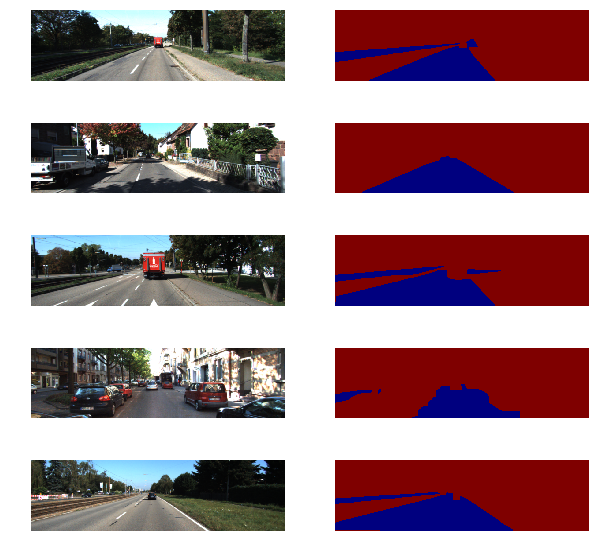

In [37]:
num_samples = 5
get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

plt.figure(figsize=(10, 10))

for batch, (images, labels) in enumerate(get_batches_fn(num_samples)):
  for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(num_samples, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(image, None)
    plt.subplot(num_samples, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(label[:,:,0], 'jet')
    
  break

In [9]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.6.0


In [8]:
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


## Cerința 1 - Încărcați în Tensorflow modelul VGG pre-antrenat și obțineți tensorii corespunzători layerelor image_input, pool3, pool4, conv_7, precum și keep_prob (pentru dropout în timpul procesului de fine-tuning)

* Folosiți [`tf.saved_model.loader.load`](https://www.tensorflow.org/api_docs/python/tf/saved_model/loader/load) pentru a încărca modelul și parametrii
* Folosiți [`tf.get_default_graph`](https://www.tensorflow.org/api_docs/python/tf/get_default_graph) pentru a obține graful default pentru threadul curent
* Folosiți [`graph.get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph) pentru a obține tensorii din modelul VGG

![alt text](https://csdl-images.computer.org/trans/tp/2017/04/figures/shelh3-2572683.gif)


In [0]:
def load_vgg(sess, vgg_path):
    """
    Încărcați în Tensorflow modelul VGG pre-antrenat
    :param sess: Sesiunea Tensorflow
    :param vgg_path: Calea către directorul vgg, conținând "variables/" și "saved_model.pb"
    :return: Tuplu de Tensori din modelul VGG (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implementați funcția
    # Folosiți tf.saved_model.loader.load pentru a încărca modelul și parametrii
    g = tf.get_default_graph()
    vgg_tag = 'vgg16'
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    
    return (tf.Graph.get_tensor_by_name(g, vgg_input_tensor_name),
            tf.Graph.get_tensor_by_name(g, vgg_keep_prob_tensor_name),
            tf.Graph.get_tensor_by_name(g, vgg_layer3_out_tensor_name),
            tf.Graph.get_tensor_by_name(g, vgg_layer4_out_tensor_name),
            tf.Graph.get_tensor_by_name(g, vgg_layer7_out_tensor_name))

In [50]:
tests.test_load_vgg(load_vgg, tf)

Tests Passed


## Cerința 2 - Adăugați layerele corespunzătoare decoderului. Construiți skip-layers folosind layerele vgg

* pentru a evita problema exploziei gradienților, folosiți [***`tf.multiply`***](https://www.tensorflow.org/api_docs/python/tf/multiply) pentru a scala rezultatul layerelor de pooling 3 și 4 înainte de a aplica convoluțiile 1x1 (folosiți `0.0001` pentru pool_3 și `0.01` pentru pool_4)
* folosiți [***`tf.layers.conv2d`***](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d) pentru a adăuga convoluțiile 1x1, pentru a reduce depth-ul layerelor la numărul de clase
* folosiți [***`tf.layers.conv2d_transpose`***](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose) pentru a mări rezoluția layerelor (2x pentru conv_7, 2x pentru primul skip-layer (între pool_4 și conv_7 upscaled) și 8x pentru cel de-al 2-lea skip layer (între pool_3 și primul skip-layer upscaled))
* folosiți [***`tf.add`***](https://www.tensorflow.org/api_docs/python/tf/add) pentru skip-layers

***Hint: Folosiți regularizare L2 pentru a preveni overfitting-ul ([`tf.contrib.layers.l2_regularizer`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/l2_regularizer))***

In [0]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Creați layerele pentru FCN; construiți skip-layers folosind layerele vgg
    :param vgg_layer3_out: Tensor pentru layerul 3
    :param vgg_layer4_out: Tensor pentru layerul 4
    :param vgg_layer7_out: Tensor pentru layerul 7
    :param num_classes: Numărul de clase
    :return: Tensorul pentru layerul de output
    """
    
    # TODO: Implementați funcția
    predict1 = tf.layers.conv2d(vgg_layer7_out, num_classes, (1, 1), kernel_initializer=tf.truncated_normal_initializer(stddev=1e-3), kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-1))
    deconv1 = tf.layers.conv2d_transpose(predict1, num_classes, (2, 2), strides=(2,2), kernel_initializer=tf.truncated_normal_initializer(stddev=1e-2), kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-1))
    
    scale4 = tf.multiply(vgg_layer4_out, 1e-2)
    predict2 = tf.layers.conv2d(scale4, num_classes, (1, 1), kernel_initializer=tf.truncated_normal_initializer(stddev=1e-3), kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-1))
    rez1 = tf.add(predict2, deconv1)
    
    deconv2 = tf.layers.conv2d_transpose(rez1, num_classes, (8, 8), strides=(8,8), kernel_initializer=tf.truncated_normal_initializer(stddev=1e-2), kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-1))
    
    scale3 = tf.multiply(vgg_layer3_out, 1e-4)
    predict3 = tf.layers.conv2d(scale3, num_classes, (1, 1), kernel_initializer=tf.truncated_normal_initializer(stddev=1e-3), kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-1))
    rez2 = tf.add(predict3, deconv2)
    
    deconv3 = tf.layers.conv2d_transpose(rez2, num_classes, (8, 8), strides=(8,8), kernel_initializer=tf.truncated_normal_initializer(stddev=1e-2), kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-1))
    
    return deconv3

In [54]:
tests.test_layers(layers)

Tests Passed


## Cerința 3 - Adăugați operațiile de loss și optimizare

* folosiți [***`tf.nn.softmax_cross_entropy_with_logits`***](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits) ca funcție de loss
* folosiți [***`tf.train.AdamOptimizer`***](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) ca optimizator

***Hint: ***
 * ***trebuie să însumați loss-ul de regularizare cu loss-ul cross-entropy pentru ca regularizarea să aibă loc (folosiți [`tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES`)](https://www.tensorflow.org/api_docs/python/tf/get_collection) pentru a obține loss-ul de regularizare)***
 * *** `nn_last_layer` și `correct_label` trebuie redimensionați pentru a deveni 2D (fiecare rând va reprezenta un pixel, iar fiecare coloană va reprezenta o clasă)***

In [0]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Adăugați operațiile de loss și optimizare
    :param nn_last_layer: Tensor pentru ultimul layer din rețea
    :param correct_label: Placeholder pentru imaginea ground-truth (imaginea label/mască)
    :param learning_rate: Placeholder pentru learning rate
    :param num_classes: Numărul de clase
    :return: (logits, optimizer, cross_entropy_loss)
    """
    # TODO: Implementați funcția
    try:
      logits = tf.reshape(nn_last_layer, [-1, num_classes])
      labels = tf.reshape(correct_label, [-1, num_classes])
      loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits) + tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    except Exception:
      loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    return (logits, tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss), loss)

In [55]:
tf.get_collection(tf.GraphKeys)

[]

In [59]:
tests.test_optimize(optimize)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Tests Passed


## Cerința 4 - Antrenați rețeaua și afișați loss-ul în timpul antrenării
* folosiți `0.5` pentru dropout
* folosiți `1e-4` pentru learning rate

In [0]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Antrenați rețeaua și afișați loss-ul în timpul antrenării
    :param sess: Sesiunea Tensorflow
    :param epochs: Numărul de epoci
    :param batch_size: Dimensiunea batch-ului de imagini
    :param get_batches_fn: Funcție pentru a obține batch-uri de imagini. Apelați folosind get_batches_fn(batch_size)
    :param train_op: Operație Tensorflow pentru a antrena rețeaua neurală
    :param cross_entropy_loss: Tensor pentru loss
    :param input_image: Placeholder pentru imagini
    :param correct_label: Placeholder pentru labeluri
    :param keep_prob: Placeholder pentru dropout
    :param learning_rate: Placeholder pentru learning rate
    """
    # TODO: Implementați funcția
    
    pass

## BONUS 1 - Aplicați rețeaua neurală pe un video

Metoda `process_image` primește un frame RGB, aplică rețeaua neurală pentru a segmenta drumul (obține o mască), aplică masca peste imaginea originală și o întoarce la output.

In [0]:
def process_image(image):
    """
    Aplică rețeaua neurală unui frame dintr-un video pentru a segmenta drumul
    : param image: Frame RGB
    : return: Imagine RGB cu masca drumului aplicată
    """
    # TODO: Implementați funcția
    
    return None

In [0]:
train_model = True
process_video = False
load_model = False
save_model = False
output_dir = None

# process image parameters
sess = tf.Session()
keep_prob = tf.placeholder(tf.float32)
loggits = tf.placeholder(tf.int32, [None, None, None, 2])
input_image = tf.placeholder(tf.int32, [None, None, 3])

In [0]:
def run():
    global image_shape, logits, sess, keep_prob, input_image, output_dir

    tf.reset_default_graph()
    
    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)
        
        epochs = 30
        batch_size = 8
        learning_rate = tf.placeholder(tf.float32)
        correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])

        # TODO: Construiți rețeaua apelând metodele load_vgg, layers și optimize
        pass

        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())

        if load_model:
            checkpoint = tf.train.get_checkpoint_state('./saved_models')
            try:
                saver.restore(sess, checkpoint.model_checkpoint_path)
                print('Successfully loaded {}'.format(checkpoint.model_checkpoint_path))
            except:
                print('Could not find network weights')

        # TODO: Antrenați rețeaua apelând metoda train_nn
        if train_model:
            pass

        # Salvează imaginile de output folosind helper.save_inference_samples
        # output_dir = helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
        
        if save_model:
            saver.save(sess, './saved_models/model')

        # BONUS 1 - Aplicați rețeaua pe un video
        if process_video:
            pass

In [0]:
run()

### Vizualizare output

In [0]:
if output_dir:
  num_samples = 10
  image_list = glob.glob(os.path.join(output_dir, '*.png'))
  img_height, img_width = image_shape

  samples = random.sample(image_list, num_samples)

  plt.figure(figsize=(10, 30))

  for i, sample in enumerate(samples):
    img = mpimg.imread(sample)
    plt.subplot(num_samples, 1, i+1)
    plt.axis('off')
    plt.imshow(img, None)

## BONUS 2 - Augmentați imaginile pentru rezultate mai bune 
 * [how-to-prepare-augment-images-for-neural-network](https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network)
 
## BONUS 3 - Antrenați rețeaua pe setul de date [cityscapes](https://www.cityscapes-dataset.com/)
